In [1]:
from fastai.text import *

In [2]:
path = '/Users/vatshiva/fastai/'

In [3]:
# batch size
bs=256

In [61]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'train.csv',num_workers=0, bs=32)
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'train.csv', vocab=data_lm.train_ds.vocab, bs=32, num_workers=0)

In [ ]:
def findLearningRate(learner):
    learner.lr_find()
    learner.recorder.plot()

In [18]:
# Saving data
data_lm.save('data_lm_export_copy.pkl')
data_clas.save('data_clas_export_copy.pkl')

## Fine Tuning: Forward learning model

In [19]:
# Fine tuning using pretrained language model AWD_LSTM
data_clas = load_data(path, 'data_clas_export_copy.pkl')
data_lm = load_data(path, 'data_lm_export_copy.pkl')
data_bwd_lm = load_data(path, 'data_lm_export_copy.pkl', bs=bs, backwards=True)
learn_fwd_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
# learn = learn.to_fp16(clip=0.1)

In [80]:
data_bwd_lm.show_batch()

idx,text
0,all and law eu xxup . white and black in its @united xxbos me for it reserve 'd she said agent res xxmaj xxunk xxup be to supposed was and economy in was journey of leg 1st ; rerouted xxunk i xxunk xxup @united xxbos ... queue the in still 'm i know to want just xxmaj . minutes 7 and hours 2 @usairways xxbos help to place in xxunk
1,been ... help n't wo it @united xxbos 24 - 10 teens among death of cause leading second the is suicide that know you did @usairways xxbos worstcustomerservice # . problems mechanical of bc denver xxmaj in trapped hours 18 . southwest xxmaj # with experience my with frustrated so xxmaj @southwestair xxbos . brilliant xxmaj . gate at checking forces luggage checked for charging xxmaj . making own your
2,". guys xxunk @united xxbos ! hrs more 8 waited i ! hours 2 delayed was that flight a for , bags in check to time flight before minutes 35 off people cut she @southwestair xxbos sorry said and number hotline hotel a us gave just xxmaj ! airline terrible xxmaj ! too us xxunk @virginamerica xxbos xxunk / t.co / / : http . fleek on 's fleet our"
3,"xxmaj . times many so happens has this @americanair xxbos xxunk / t.co / / : http xxunk inconvenience epic this from get i will trips free many how and 669 flight with on going 's what @jetblue xxbos properly cleaned n't was it because vomit of reeks xxup that flight a onto us boarding then and , hour an for flight my delaying for thanks @united xxbos . #"
4,"? online companion a with trips change longer no we can why xxmaj @southwestair xxbos crazy 's it , flights int'l inbound of because delayed is flight domestic single every when but , understandable is weather xxmaj . thanks @united xxbos . there right fa xxup great a 's that xxunk @southwestair xxbos unitedairlines # , know me let to xxunk have even n't did and ers of out get"


The `Learner` object we get is frozen by default, which means we only train the embeddings at first (since some of them are random).

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


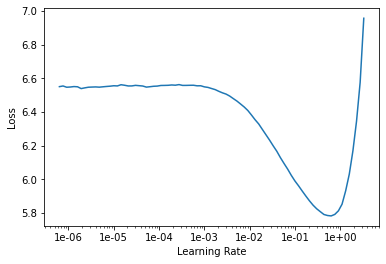

In [8]:
# finding suitable learning rate for training
findLearningRate(learn_fwd_lm)

In [20]:
learn_fwd_lm.fit_one_cycle(1, 1e-01, moms=(0.9,0.8), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.711770,4.052623,0.254222,02:21


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


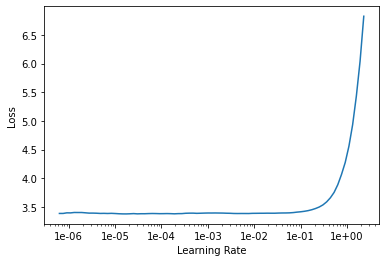

In [10]:
# finding suitable learning rate for training
findLearningRate(learn_fwd_lm)

In [21]:
# unfreezing the model to fine tune it
learn_fwd_lm.unfreeze()
learn_fwd_lm.fit_one_cycle(1, 1e-3, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.848291,3.871294,0.276395,04:17


### Saving Forward Encoder

In [22]:
learn_fwd_lm.save_encoder('ft_enc')

## Backward Learning Model

In [23]:
learn_bwd_lm = language_model_learner(data_bwd_lm, AWD_LSTM)
# learn = learn.to_fp16(clip=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


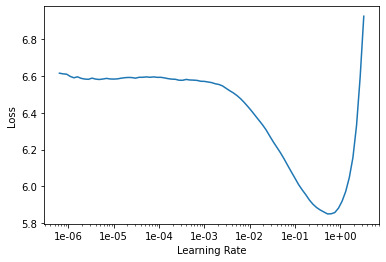

In [14]:
# finding suitable learning rate for training
findLearningRate(learn_bwd_lm)

In [24]:
learn_bwd_lm.fit_one_cycle(1, 1e-1, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,5.226597,4.153471,0.282682,02:56


In [25]:
learn_bwd_lm.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


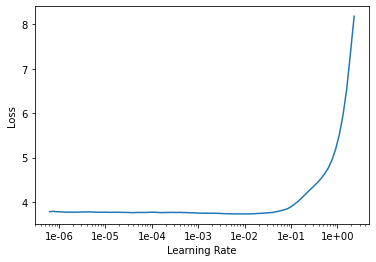

In [17]:
# finding suitable learning rate for training
findLearningRate(learn_bwd_lm)

In [26]:
learn_bwd_lm.fit_one_cycle(1, 2e-3, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,4.169962,3.914448,0.307608,04:21


### Saving Backward encoder

In [27]:
learn_bwd_lm.save_encoder('bwd_enc')

## Forward Classifier

In [28]:
# data_clas = load_data(path, 'data_clas_export_copy.pkl')
learn_fwd_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_fwd_clas.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8198 items)
x: TextList
xxbos @southwestair @fortunemagazine xxmaj congratulations !,xxbos @jetblue xxmaj is there something going on with your alerts ? xxmaj flight 's been delayed several times for my parents and i 'm not receiving any alerts .,xxbos @usairways xxunk " xxmaj that 's unusual " means we screwed up but will never admit to it ! # goingforgreatnessfail,xxbos @usairways your saving xxunk was our flight attendant xxmaj dallas who was amazing . wish he would transfer to xxmaj delta where i would see him again,xxbos @united xxmaj ha … you rebooked me in to an 11 hr layover & & are xxunk me of a night with my family . xxmaj too xxmaj late xxmaj flight for that . xxmaj just fly on time for once .
y: CategoryList
neutral,negative,negative,negative,negative
Path: /Users/vatshiva/fastai;

Valid: LabelList (2050 items)
x: TextList
xxbos @united xxmaj the xxup den xxunk agent ( 9:30am ) was amazing . xxmaj the xxunk at check in ?

In [5]:
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac xxunk / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @americanair xxmaj hi . i have xxup koa - xxup lax - xxup phl - xxup ord booked as a 1-way xxunk xxunk . xxmaj if i called to chnge it to xxup koa - xxup lax - xxup phx - xxup ord would i have to pay any fees,neutral
"xxbos @usairways 4 segments , 4 / 4 delayed . xxmaj gnv > xxup ctl . xxup ctl > xxup jan . xxup jan > xxup ctl . xxup ctl > xxup gnv . xxmaj my year off from flying with you guys was the way to go .",negative
xxbos @usairways i wish we were on our way . xxmaj now there 's a problem w / de - icing . xxmaj three & & 1 / 2 hour delay so far & & xxunk not sure if we 'll be taking off .,negative
"xxbos @united xxmaj united xxmaj club team is xxup a+ & & got me a seat xxmaj late xxmaj flightr . xxmaj still , not sure why a last min xxup ual xxmaj cancelled xxmaj flightlation costs me $ yet overbooked folks get $ ?",negative


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


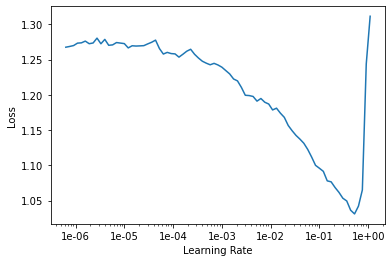

In [23]:
# finding suitable learning rate for training
findLearningRate(learn_fwd_clas)

In [29]:
lr = 1e-01
learn_fwd_clas.fit_one_cycle(1, lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.732591,0.554433,0.794634,02:20


In [30]:
learn_fwd_clas.freeze_to(-2)

epoch,train_loss,valid_loss,accuracy,time


Traceback (most recent call last):
  File "/opt/anaconda3/envs/fastai/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/envs/fastai/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/envs/fastai/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/envs/fastai/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/opt/anaconda3/envs/fastai/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/opt/anaconda3/envs/fastai/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/anaconda3/envs/fastai/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSE

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


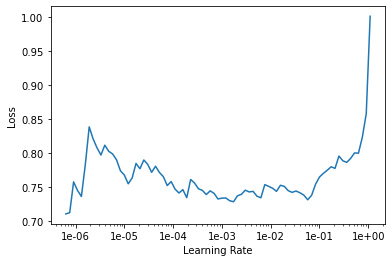

In [94]:
# finding suitable learning rate for training
findLearningRate(learn_fwd_clas)

In [31]:
# learn.freeze_to(-2)
lr /= 2
learn_fwd_clas.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.654318,0.511059,0.805854,02:47


In [32]:
learn_fwd_clas.freeze_to(-3)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


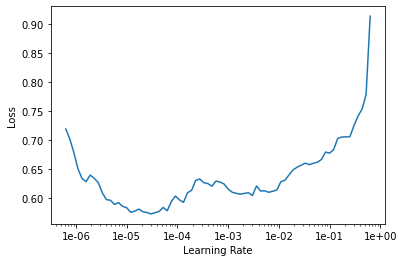

In [97]:
# finding suitable learning rate for training
findLearningRate(learn_fwd_clas)

In [33]:
lr

0.05

In [34]:
# lr /= 2
lr /= 5
learn_fwd_clas.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.620712,0.478525,0.814146,04:40


In [35]:
learn_fwd_clas.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


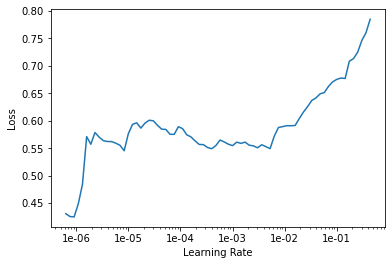

In [101]:
# finding suitable learning rate for training
findLearningRate(learn_fwd_clas)

In [36]:
lr /= 1000
lr

1e-05

In [37]:
learn_fwd_clas.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.516506,0.473004,0.818049,05:51
1,0.516553,0.472901,0.819024,05:49


### Saving Forward Classifier

In [38]:
learn_fwd_clas.save('fwd_clas')

In [40]:
learn_fwd_clas.export('fwd_clas.pkl')

## Backward Classifier 

In [41]:
data_clas_bwd = load_data(path, 'data_clas_export_copy.pkl', bs=bs, backwards=True)
learn_bwd_clas = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_bwd_clas.load_encoder('bwd_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8198 items)
x: TextList
xxbos @southwestair @fortunemagazine xxmaj congratulations !,xxbos @jetblue xxmaj is there something going on with your alerts ? xxmaj flight 's been delayed several times for my parents and i 'm not receiving any alerts .,xxbos @usairways xxunk " xxmaj that 's unusual " means we screwed up but will never admit to it ! # goingforgreatnessfail,xxbos @usairways your saving xxunk was our flight attendant xxmaj dallas who was amazing . wish he would transfer to xxmaj delta where i would see him again,xxbos @united xxmaj ha … you rebooked me in to an 11 hr layover & & are xxunk me of a night with my family . xxmaj too xxmaj late xxmaj flight for that . xxmaj just fly on time for once .
y: CategoryList
neutral,negative,negative,negative,negative
Path: /Users/vatshiva/fastai;

Valid: LabelList (2050 items)
x: TextList
xxbos @united xxmaj the xxup den xxunk agent ( 9:30am ) was amazing . xxmaj the xxunk at check in ?

In [108]:
lr

1e-05

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


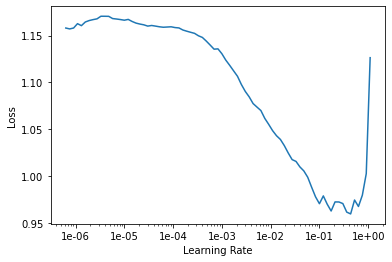

In [109]:
# finding suitable learning rate for training
findLearningRate(learn_bwd_clas)

In [42]:
lr = 0.05

In [43]:
learn_bwd_clas.fit_one_cycle(1, lr, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.830777,0.736121,0.666341,02:07


In [44]:
learn_bwd_clas.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


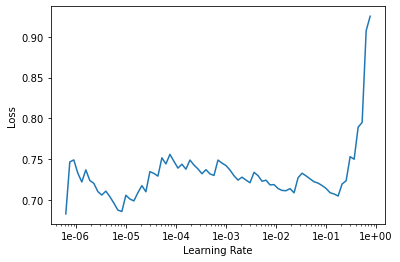

In [114]:
# finding suitable learning rate for training
findLearningRate(learn_bwd_clas)

In [45]:
# learn_bwd.freeze_to(-2)
# lr = 0.018
lr /= 2
learn_bwd_clas.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.727838,0.574906,0.785366,02:27


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


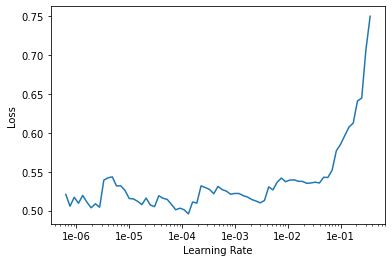

In [14]:
# finding suitable learning rate for training
findLearningRate(learn_bwd_clas)

In [46]:
learn_bwd_clas.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


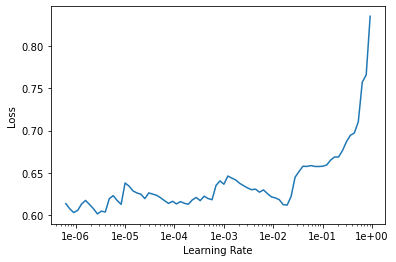

In [117]:
# finding suitable learning rate for training
findLearningRate(learn_bwd_clas)

In [47]:
lr /= 5

In [48]:
lr

0.005

In [49]:
learn_bwd_clas.fit_one_cycle(3, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.653831,0.510238,0.807317,02:56
1,0.607410,0.472672,0.820488,02:59
2,0.560244,0.458468,0.823415,02:58


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


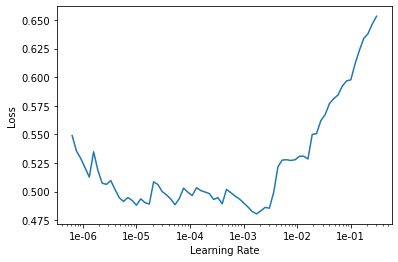

In [50]:
# finding suitable learning rate for training
findLearningRate(learn_bwd_clas)

In [51]:
lr

0.005

In [52]:
learn_bwd_clas.unfreeze()
lr /= 5
learn_bwd_clas.fit_one_cycle(8, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.506010,0.455041,0.823902,03:58
1,0.499544,0.456889,0.822439,04:18
2,0.495546,0.456161,0.822439,04:37
3,0.477279,0.451428,0.824878,04:52
4,0.458020,0.449901,0.823415,04:53
5,0.445502,0.450082,0.824878,05:06
6,0.427579,0.450357,0.822927,04:46
7,0.417625,0.451773,0.821951,04:44


### Saving Backward Classifier

In [54]:
learn_bwd_clas.save('bwd_clas')

In [56]:
learn_bwd_clas.export('bwd_clas.pkl')

In [44]:
# data_clas_bwd = load_data(path, 'data_clas_export_copy.pkl')
# learn_fwd = text_classifier_learner(data_clas, AWD_LSTM, pretrained=False).load('fwd_clas_copy', with_opt=False);
# learn_fwd.export(file = 'export_clas_fwd.pkl')

## Accuracy

In [57]:
pred_fwd,lbl_fwd = learn_fwd_clas.get_preds(ordered=True)

In [58]:
pred_bwd,lbl_bwd = learn_bwd_clas.get_preds(ordered=True)

In [59]:
final_pred = (pred_fwd+pred_bwd)/2

In [60]:
accuracy(final_pred, lbl_fwd)

tensor(0.8322)